# TP2: Approximate Inference in Classification
## **The answers in the PDF and the Notebook (ipynb) are the same, but the PDF may present them more clearly.**

In classification taks, even for a mere Logistic Regression, we don't have access to a closed form of the posterior $p(\pmb{w} \vert \mathcal{D})$. Unlike in Linear regression, the likelihood isn't conjugated to the Gaussian prior anymore. We will need to approximate this posterior.

During this session, we will explore and compare approximate inference approaches on 2D binary classification datasets. Studied approaches include Laplacian approximation, variational inference with mean-field approximation and Monte Carlo dropout.

**Goal**: Take hand on approximate inference methods and understand how they works on linear and non-linear 2D datasets.

In Bayesian regression, given the prior distribution \( p(w) \), we aim to compute the following two distributions:

- **The posterior distribution:**  
  $$
  p(w \mid D) \propto p(y \mid X, w) p(w)
  $$

- **The predictive distribution:**  
  $$
  p(y \mid x^*, D) = \int p(y \mid x^*, w) p(w \mid D) \, dw
  $$

For Bayesian linear regression, the posterior distribution is often Gaussian, allowing us to compute the predictive value \( y^* \) analytically.

However, for Bayesian logistic regression, \( p(Y \mid X, w) \) is no longer Gaussian, so the posterior distribution \( p(w \mid D) \) does not have an explicit solution. Approximate inference methods, such as Maximum A Posteriori (MAP), Laplacian approximation, and variational inference, are therefore required.

In this chapter, we will explore various approximate inference methods for binary classification problems and compare their performance. Additionally, we will implement Bayesian Neural Networks (BNNs) using variational inference and Monte Carlo dropout.


### All Imports and Useful Functions

Here we are going to install and import everything we are going to need for this tutorial.

**Note**: *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [ ]:
#@title Import libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

In [ ]:
#@title Useful plot function
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4,-7),
                           nbh=2, cmap='RdBu'):
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))

    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = torch.sigmoid(model(test_tensor))
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = torch.sigmoid(model(test_tensor))

            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)

        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)

            pred = outputs.mean(0).squeeze()

    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title('Classification Analysis')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    CS = ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.clabel(CS, inline=1, fontsize=10)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Part I: Bayesian Logistic Regression

In linear regression, model prediction is of the continuous form $f(\pmb{x})=\pmb{w}^T\pmb{x}+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $\pmb{x}$.
For simplicity, let's consider here binary classification:
$$f(\pmb{x}) = \sigma(\pmb{w}^T\pmb{x} + b)$$
where $\sigma(t)= \frac{1}{1+e^t}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior:
$$ p(\pmb{w}) = \mathcal{N}(\pmb{w}; \pmb{\mu}_0, \pmb{\Sigma}_0^2) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

In this section, we use the binary classification clusters generated by the `make_blob` function as the training dataset. Subsequently, we will train the decision boundary for the binary classification problem using three approximate inference methods: Maximum A Posteriori (MAP), Laplacian approximation, and variational inference.

### I.0 Dataset

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 400 #@param
TEXT_LOCATION = (-5,-7)

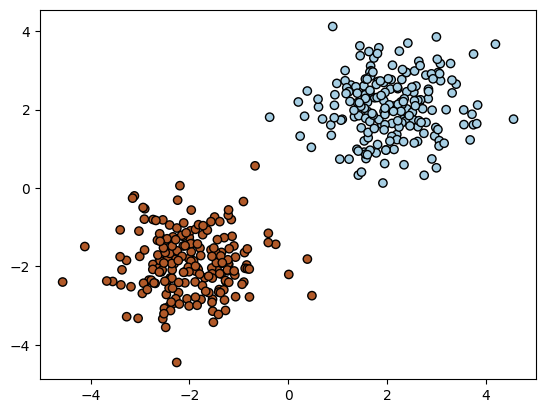

In [ ]:
# Load linear dataset
X, y = make_blobs(n_samples=NB_SAMPLES, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()


### I.1 Maximum-A-Posteriori Estimate


In this "baseline", we reduce our posterior distribution $p(\pmb{w} | \mathcal{D})$ to a point estimate $\pmb{w}_{MAP}$. For a new sample $\pmb{x^*}$, the predictive distribution can then be approximated by
$$ p(\mathbf{y} = 1|\pmb{x^*},\mathcal{D}) = \int p(\mathbf{y} =1 |\pmb{x},\pmb{w})p(\pmb{w} | \mathcal{D})d\pmb{w} \approx p(y =1 |\pmb{x},\pmb{w}_{\textrm{MAP}}).$$
This approximation is called the **plug-in approximation**.

The point estimate corresponds to the Maximum-A-Posteriori minimum given by:
$$ \pmb{w}_{\textrm{MAP}} = arg \max_{\pmb{w}} p(\pmb{w} \vert \mathcal{D}) = arg \max_{\pmb{w}} p(\mathcal{D} \vert \pmb{w})p(\pmb{w}) = arg \max_{\pmb{w}} \prod_{n=1}^N p(y_n \vert \pmb{x}_n, \pmb{w})p(\pmb{w}) $$
Looking for the maximum solution of previous equation is equivalent to the minimum solution of $- \log p(\pmb{w} \vert \mathcal{D})$. In case of a Gaussian prior, it can further be derived as:
$$ \pmb{w}_{\textrm{MAP}} = arg \min_{\pmb{w}} \sum_{n=1}^N \big ( -y_n \log \sigma(\pmb{w}^T \pmb{x}_n + b) - (1-y_n) \log (1 - \sigma(\pmb{w}^T \pmb{x}_n + b)) + \frac{1}{2 \sigma_0^2} \vert \vert \pmb{w} \vert \vert_2^2 \big ) $$

Note that:
- This actually correspond to the minimum given by the standard **cross-entropy** loss in classification with a weight decay regularization
- Unlike in linear regression, $\pmb{w}_{MAP}$ **cannot be computed analytically**
- But we can use optimization methods to compute it, e.g. **stochastic gradient descent**
- Nevertheless, we only obtain a **point-wise estimate**, and not a full distribution over parameters $\pmb{w}$


Consequently, **the objective is simply to implement and train a Logistic Regression model** with Pytorch and then compute $p(\mathbf{y} = 1|\pmb{x}^*,\mathcal{D})$ on a new sample $\pmb{x}^*$ as in a deterministic model.

We approximate the posterior distribution by taking only the point with the highest probability, i.e.,  
$$
p(\pmb{w} \vert \mathcal{D}) = \delta(\pmb{w} - \pmb{w}_{\textrm{MAP}}),
$$  
such that the predictive distribution can be approximated as:  
$$
p(\mathbf{y} = 1 \mid \pmb{x}^*, \mathcal{D}) = \int p(\mathbf{y} = 1 \mid \pmb{x}, \pmb{w}) p(\pmb{w} \mid \mathcal{D}) d\pmb{w} \approx p(y = 1 \mid \pmb{x}, \pmb{w}_{\textrm{MAP}}).
$$

The value of $ \pmb{w}_{\textrm{MAP}} $ can be determined by the following optimization problem:  
$$
\begin{aligned}
    \pmb{w}_{\textrm{MAP}} &= \arg \max_{\pmb{w}} p(\pmb{w} \vert \mathcal{D}) \\
    &= \arg \max_{\pmb{w}} p(\mathcal{D} \vert \pmb{w}) p(\pmb{w}) \\
    &= \arg \max_{\pmb{w}} \prod_{n=1}^N p(y_n \vert \pmb{x}_n, \pmb{w}) p(\pmb{w}) \\
    &= \arg \min_{\pmb{w}} \sum_{n=1}^N -\log(p(y_n \vert \pmb{x}_n, \pmb{w})) - \log(p(\pmb{w})) \\
    &= \arg \min_{\pmb{w}} \sum_{n=1}^N \big( -y_n \log \sigma(\pmb{w}^T \pmb{x}_n + b) \\
    &\quad - (1 - y_n) \log (1 - \sigma(\pmb{w}^T \pmb{x}_n + b)) \big) + \frac{1}{2 \sigma_0^2} \Vert \pmb{w} \Vert_2^2.
\end{aligned}
$$  
where $ \sigma(\cdot) $ represents the sigmoid function.

This approach is also known as the plug-in approximation and is generally used as a baseline method.


In [ ]:
class LogisticRegression(nn.Module):
    """ A Logistic Regression Model with sigmoid output in Pytorch"""
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc(x)

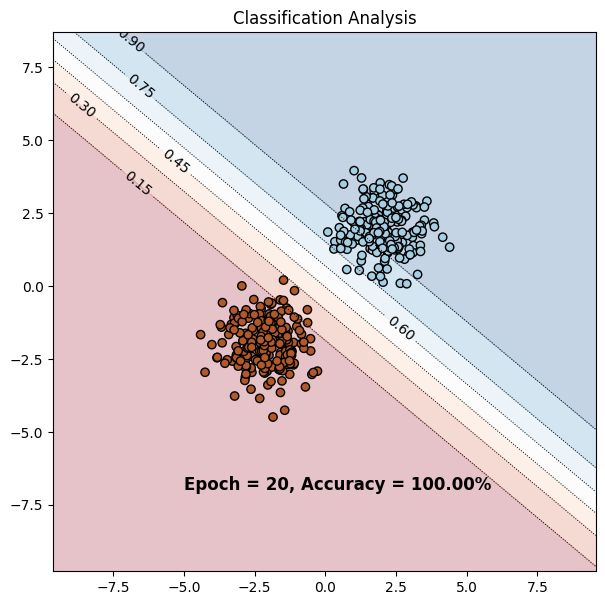

In [ ]:
#@title **[CODING TASK]** Train a Logistic Regression model with stochastic gradient descent for 20 epochs.

net = LogisticRegression(input_size=X.shape[1])
net.train()
criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.SGD(net.parameters(), lr=0.2)

fig, ax = plt.subplots(figsize=(7,7))

# ============ YOUR CODE HERE ============
# Train previously defined network for 20 epochs with SGD
# and plot result for each epoch by uncommenting function below

for epoch in range(20):  # loop over the dataset multiple times
    # ============ YOUR CODE HERE ============
    output = net(X).squeeze()
    # Loss function : binary cross entropy + add a L2 regularization "manually" (WEIGHT_DECAY ||w||^2)
    loss = criterion(output, y) + WEIGHT_DECAY*net.fc.weight.norm()**2

    # zero the parameter gradients
    optimizer.zero_grad()

    # backward + optimize
    loss.backward()
    optimizer.step()
    # For plotting and showing learning process at each epoch
    plot_decision_boundary(net, X, y, epoch, ((output>=0.0) == y).float().mean(),
                          model_type='classic', tloc=TEXT_LOCATION)

**[Question 1.1]: Analyze the results provided by previous plot. Looking at $p(\mathbf{y}=1 | \pmb{x}, \pmb{w}_{\textrm{MAP}})$, what can you say about points far from train distribution?**

The figure above shows the classification results after 20 training iterations, with an accuracy of 100%. The background in different colors represents the predicted probability $ p(y=1 \mid x, w_{\text{MAP}}) $ at any point, and the dashed lines denote iso-probability contours.

The model's results resemble linear classification, which is clearly inconsistent with the actual situation. For points far from the training distribution, even though the model provides a predicted probability for these points, we know that the confidence in such predictions is relatively low. However, this uncertainty is not reflected in the figure. This demonstrates that MAP is a rather crude approximation method, and other more advanced approaches can be used to better capture the prediction uncertainty of the model in unseen regions.


### I.2 Laplace Approximation


We will use Laplace approximation to estimate the intractable posterior $p(\pmb{w} | \mathcal{D})$.

Here, $p(\pmb{w} | \mathcal{D})$ is approximated with a normal distribution $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ where:

- the mean of the normal distribution $\pmb{\mu}_{lap}$ corresponds to the mode of $p(\pmb{w} | \mathcal{D})$. In other words, it simply consists in taking the optimum weights of Maximum-A-Posteriori estimation :
$$\pmb{\mu}_{lap} = \pmb{w}_{\textrm{MAP}} = \arg \min_{\pmb{w}} -\log p(\pmb{w} | \mathcal{D})$$.
- the covariance matrix is obtained by computing the Hessian of the loss function $-\log p(\pmb{w} \vert \mathcal{D})$ at $\pmb{w}=\pmb{w}_{\textrm{MAP}}$:
$$(\pmb{\Sigma}^2_{lap})^{-1} = \nabla\nabla_{\pmb{w}} [p(\pmb{w} \vert \mathcal{D}) ]_{\pmb{w}=\pmb{w}_{\textrm{MAP}}}$$

From the results above, we observe that using MAP as a replacement for the posterior probability $p(\pmb{w} \mid \mathcal{D})$ is rather crude. Now, we attempt to approximate the posterior probability $p(\pmb{w} \mid \mathcal{D})$ with a Gaussian distribution $q(\pmb{w})$.

$$
p(\pmb{w} \mid \mathcal{D}) \approx q(\pmb{w}) = \mathcal{N}(\pmb{w}; \pmb{\mu}, \pmb{\Sigma})
$$

- The mean of the Gaussian distribution is determined by $p(\pmb{w} \mid \mathcal{D})$:

  $$
  \pmb{\mu}_{\text{lap}} = \pmb{w}_{\textrm{MAP}} = \arg \min_{\pmb{w}} -\log p(\pmb{w} \mid \mathcal{D})
  $$

- The variance of the Gaussian distribution is given by the inverse of the Hessian matrix of $p(\pmb{w} \mid \mathcal{D})$ at $\pmb{w} = \pmb{w}_{\textrm{MAP}}$:

  $$
  (\pmb{\Sigma}_{\text{lap}})^{-1} = \nabla \nabla_{\pmb{w}} \big[ -\log p(\pmb{w} \mid \mathcal{D}) \big]_{\pmb{w} = \pmb{w}_{\textrm{MAP}}}
  $$


In [ ]:
#@title **[CODING TASK]** Extract μ_lap from previously trained model.
# NB: Select only weights parameters (without bias)

# ============ YOUR CODE HERE ============
w_map = net.fc.weight
print(w_map)

Parameter containing:
tensor([[0.6777, 0.8374]], requires_grad=True)


To compute the Hessian, we first compute the gradient at $\pmb{w}_{\textrm{MAP}}$:

In [ ]:
# Computing first derivative w.r.t to model's weights
optimizer.zero_grad()
output = net(X).squeeze()
loss = criterion(output, y) + WEIGHT_DECAY*net.fc.weight.norm()**2
gradf_weight = grad(loss, net.fc.weight, create_graph=True)[0]
print(gradf_weight)

tensor([[-0.0344, -0.0102]], grad_fn=<AddBackward0>)


In [ ]:
#@title **[CODING TASK]** Compute the Hessian from the previous derivative

# ============ YOUR CODE HERE ============
# Apply the same grad function on each scalar element of the gradient to get
# each raw of the Hessian. Concatenate both and compute the covariance
# by inverting the Hessian
# NB: to avoid accumulated gradient when debugging and running the cell
# multiple times, you should convert your grad results to numpy straight away

# Compute the Hessian
hess_weights = []
for g in gradf_weight.view(-1):  # Iterate over each gradient element
    optimizer.zero_grad()  # Clear previous gradients
    hess_grad = grad(g, net.fc.weight, retain_graph=True)[0]  # Compute second derivative
    hess_weights.append(hess_grad.view(-1).detach().numpy())  # Convert to numpy to avoid gradient accumulation

hess_weights = np.array(hess_weights)  # Convert to numpy array

# Compute the covariance matrix (inverse of Hessian)
Sigma_laplace = np.linalg.inv(hess_weights)

print("Hessian matrix (weights):", hess_weights)
print("Sigma_laplace (covariance):", Sigma_laplace)

Hessian matrix (weights): [[0.29169622 0.1443217 ]
 [0.1443217  0.26537022]]
Sigma_laplace (covariance): [[ 4.690282  -2.5508115]
 [-2.5508115  5.15558  ]]


We now compute the posterior approximate $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ with the parameters found.

Given this distribution, we can compute the posterior thanks to Monte-Carlo sampling and plot results for the last epoch corresponding to $\pmb{w}_{\textrm{MAP}}$:

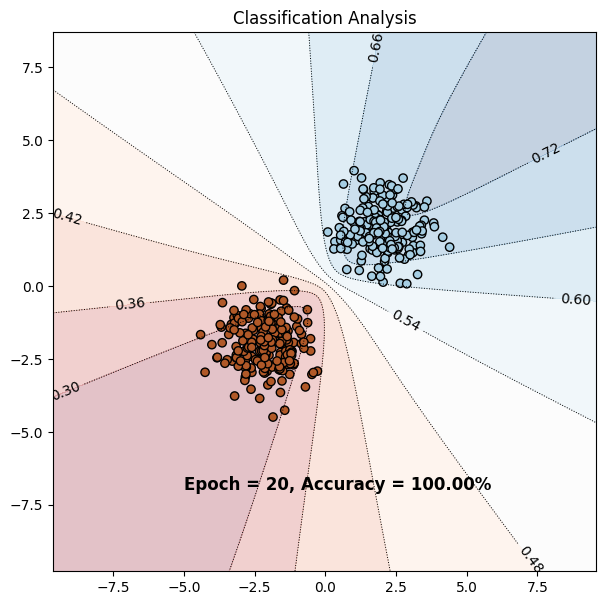

In [ ]:
# Defining posterior distribution
# laplace_posterior =  np.random.multivariate_normal(w_map.detach().numpy().reshape(2,), Sigma_laplace.detach().numpy(), NB_SAMPLES)
laplace_posterior =  np.random.multivariate_normal(w_map.detach().numpy().reshape(2,), Sigma_laplace, NB_SAMPLES)

# Plotting results
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.0) == y).float().mean(), model_type='laplace',
                       tloc=TEXT_LOCATION, nsamples=NB_SAMPLES, posterior=laplace_posterior)

**[Question 1.2]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**


After 20 iterations, the Laplace Approximation also achieved an accuracy of 100%. The background color represents the probability at each point $p(y=1 \mid x, \mathcal{D})$, and the dashed lines indicate iso-probability contours.

Compared to the MAP estimate, the iso-probability contours of the Laplace Approximation are no longer linear but resemble an umbrella-like structure, with denser contours near the decision boundary. This distribution better reflects the uncertainty for points far from the training distribution and aligns more closely with real-world scenarios, especially as the model behaves more cautiously in regions not well-covered by the training data. However, there are still certain limitations, such as for points in the bottom-left and top-right corners of the figure.


**[Question 1.3]: Comment the effect of the regularisation hyper-parameter WEIGHT_DECAY.**

The regularization hyper-parameter `WEIGHT_DECAY` represents the L2 regularization method, which directly acts on the model's weight parameters. Its purpose is to add a weight penalty term to the loss function:

$$
L_{\text{total}} = L_{\text{loss}} + \texttt{weight_decay} \cdot \| \pmb{w} \|_2^2
$$

By imposing a weight penalty during the optimization process, `WEIGHT_DECAY` can limit excessively large weights, thus preventing the model from overfitting or underfitting and enhancing the generalization ability of the model.


### I.3 Variational Inference

In this part, we will reimplement variational inference by hand with Pytorch tools. <br/><br/>

**Optimization problem**  
We define an approximating variational distribution $q_{\pmb{\theta}}(\pmb{w})$ parametrized by $\pmb{\theta}$ and minimize its Kullback-Leibler (KL) divergence with the unknown true posterior $p(\pmb{w} \vert \mathcal{D})$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_{\pmb{\theta}}(\pmb{w})$:

$$ arg \max_{\pmb{\theta}}~ \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \big [\underbrace{\log p(\mathcal{D} \vert \pmb{w})}_{likelihood} \big ] - \underbrace{\textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))}_{regularization} $$
where we have a likelihood term  and the KL divergence between the prior and the variational distribution. By assuming that samples are *i.i.d*, maximizing the ELBO is equivalent to minimizing the following loss:
$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \Big [ \log p(y_n \vert \pmb{x}_n, \pmb{w}) \Big ]+ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})) = NLL(\pmb{\theta}; \mathcal{D}) + \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))$$


- **Likelihood term:** computind the expectations for the negative log likelihhod $NLL(\pmb{\theta}; \mathcal{D})$ can be tedious mathematics, or maybe not even possible.
    - **Monte Carlo estimator:** luckily, we can get estimates of the expectations by taking samples from $q_{\pmb{\theta}}(\pmb{w})$ and average over those results. Even more simple, we can show that using only one sample is stil an unbiased gradient estimator. Hence, $NLL(\pmb{\theta}; \mathcal{D})$ rewrites:
$$ NLL(\pmb{\theta}; \mathcal{D}) =  \sum_{n=1}^N - \log p(y_n \vert \pmb{x}_n, \pmb{w}_s),$$
where $\pmb{w}_s \sim q_{\pmb{\theta}}$ is a sample from the variational distribution. <br><br>

- **Mean-field approximation:** assumes a factorisation over weights: $ q_{\pmb{\theta}}(\pmb{w}) = \prod\limits_{i=1}^{N_w} q_{\pmb{\theta}}(w_{i}) =\prod\limits_{i=1}^{N_w} \mathcal{N}(w_{i}; \mu_{i}, \sigma^2_{i}) $. We use this Mean-field approximation for the variational posterior $q_{\pmb{\theta}}(\pmb{w})$ and the prior $p(\pmb{w})$.
    - **Reparametrization trick:** if we start taking samples from $q_{\pmb{\theta}}$, we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples $\pmb{w}_{i} \sim \mathcal{N}(\mu_{i},\sigma_{i}^2)$ from the distribution. <br>
Instead of sampling directly from the variational distribution, we sample from a centered isotropic multivariate Gaussian and recreate samples from the variational distribution. Now the stochasticity of $\pmb{\varepsilon}$ is external and will not prevent the flow of gradients.
$$ \pmb{w}_{i} = \mu_{i}+ \sigma_{i}\odot\pmb{\varepsilon}_s$$
where $\pmb{\varepsilon}_s \sim \mathcal{N}(0,1)$.
<br/><br>  
    - **Closed-for solution for the regularization term $ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})$**. For univariate Gaussian distribution, the KL term between the approximate variational distribution $q_{\theta}(w)\sim \mathcal{N}(\mu_{i},\sigma_{i}^2)$ and the prior $p(w)\sim \mathcal{N}(0,\sigma_{p}^2)$ rewrites:

$$
\textrm{KL}\left[q_{\theta}(w))\vert\vert p(w) \right]= \sum\limits_{i=1}^d \left[ log\left(\frac{\sigma_{p}}{\sigma_{i}}\right) + \frac{\sigma_i^2+\mu_i^2}{2\sigma_{p}^2} - \frac{1}{2} \right]
$$

**Predictive distribution**  
For a new sample $\pmb{x^*}$, the predictive distribution can be approximated using **Monte Carlo sampling**:
\begin{equation}
p(\mathbf{y} =1|\pmb{x}^*,\mathcal{D}) \approx \int p(\mathbf{y} = 1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(\mathbf{y}=1|\pmb{x}^*,\pmb{w}_s)
\end{equation}
where $\pmb{w}_s \sim q^*_{\pmb{\theta}}$ are samples from the optimum variational distribution.

#### Step 1: Implement a variational layer

Let's first implement variational inference for a single layer. Remind that we defined our Logistic regression model as $f(x) = \sigma(w^T x + b)$ where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function. As such, we need to place Gaussian distributions on parameters $w$ and $b$.  

**Implementation constraint** Variance can not be negative. To avoid numerical issues, we will use $\rho$. Std can be retrieve with the following formula: $ \sigma^2 = \log(1 + e^{\rho}) $

In [ ]:
#@title **[CODING TASK]** Implement a variational layer from scratch

class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, input_size, output_size, prior_std):
        super().__init__()
        self.prior_std = prior_std  # Standard deviation of the Gaussian prior
        # Initialize the variational parameters for weight and bias with nn.Parameter.
        # Mean and rho can be initialised to zeros . We use point-base estimate for biaises (no rho)
        self.w_mu = nn.Parameter(torch.zeros(input_size, output_size))  # Mean of weights, (input_size, output_size)
        self.w_rho = nn.Parameter(torch.zeros(input_size, output_size))  # Rho for weights, (input_size, output_size)
        self.b_mu = nn.Parameter(torch.zeros(output_size))  # Mean of biases (point-based), (output_size, )

    def sampling(self, mu, rho):
        "Sample weights using the reparametrization trick"
        # Given parameter mu and rho, return sampling using the reparametrization trick.
        std = torch.log1p(torch.exp(rho))**0.5  # Softplus activation to ensure positivity, sigma
        epsilon = torch.randn_like(std)  # Sample epsilon ~ N(0, 1)
        return mu + std * epsilon  # Reparameterization: w = mu + sigma * epsilon

    def kl_divergence(self):
        "Compute KL divergence between all univariates posterior q(w)~N(\mu_i,\sigma_i) and the prior p(w)~N(0,\sigma_p) "
        # Compute sigma from rho
        sigma = torch.log1p(torch.exp(self.w_rho))**0.5

        # Compute KL divergence for each weight
        kl = torch.sum(
            torch.log(self.prior_std / sigma) + (sigma ** 2 + self.w_mu ** 2) / (2 * self.prior_std ** 2) - 0.5
        )
        return kl

    def forward(self, x):  # x (batch_size, input_size)
        "Usual forward function for pytorch layer"
        # Sample parameters w and b using self.sampling
        w_sampled = self.sampling(self.w_mu, self.w_rho)  # (input_size, output_size)
        b_sampled = self.b_mu  # Biases are point-based (output_size, )
        # Perform a forward pass using the sampled parameters
        out = torch.matmul(x, w_sampled) + b_sampled  # (batch_size, output_size)
        return out

#### Step 2: Variational Logistic Regression

Now, let's use this `LinearVariational` layer in a Logistic regression model.

In [ ]:
# class VariationalLogisticRegression(nn.Module):
#     def __init__(self, input_size, prior_var=4.0):
#         super().__init__()
#         self.prior_var = prior_var
#         self.fc_var =  LinearVariational(input_size, 1,self.prior_var)

#     def forward(self, x):
#         out = self.fc_var(x)
#         return torch.sigmoid(out)

#     def kl_divergence(self):
#         return self.fc_var.kl_divergence()

class VariationalLogisticRegression(nn.Module):
    def __init__(self, input_size, prior_std=4.0):
        super().__init__()
        self.prior_std = prior_std  # Standard deviation of the Gaussian prior
        # Define a variational linear layer with a single output (binary classification)
        self.fc_var =  LinearVariational(input_size, 1, self.prior_std)

    def forward(self, x):
        out = self.fc_var(x)  # Pass input through the variational linear layer
        return torch.sigmoid(out)  # Apply sigmoid activation for binary classification

    def kl_divergence(self):
        return self.fc_var.kl_divergence()

**[Question 1.4]: Comment the code of the VariationalLogisticRegression and LinearVariational classes.**

Using the method described above, we can now define the `LinearVariational` class and implement Variational Logistic Regression using its variational layer.

- In the `LinearVariational` class, the inputs are `input_size`, `output_size`, and `prior_std`. Three tensors, `w_mu`, `w_rho`, and `b_mu`, are initialized as parameters to be optimized. Here, `w_mu` and `w_rho` determine the mean and variance of the Gaussian distribution from which $\pmb{w}$ is sampled, and `b_mu` determines the bias term in the output, i.e., $y = \pmb{x} \cdot \pmb{w} + b$. This class also defines the `kl_divergence` method to conveniently collect the divergence loss for parameter optimization.

- In the `VariationalLogisticRegression` class, the inputs are `input_size` and `prior_std` (defaulting to 4.0). A variational fully connected layer is defined using `LinearVariational`, and the value of `kl_divergence` is collected using this fully connected layer.


**We can now train our variational model as any other network in Pytorch**

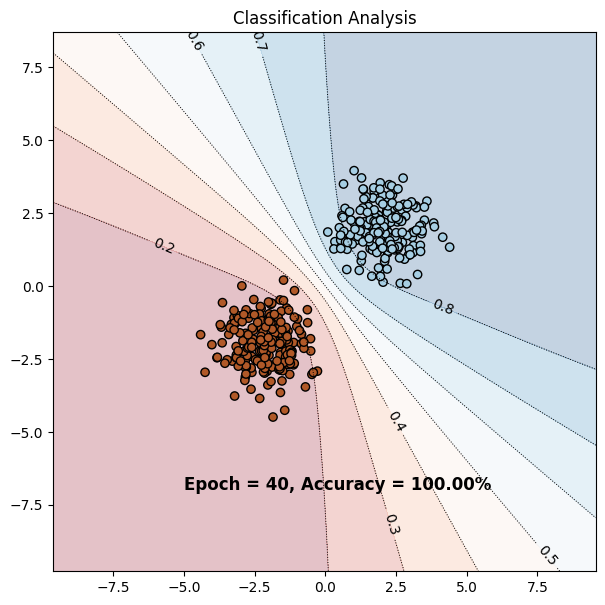

In [ ]:
# Initialize a Variational Logistic Regression model
var_net = VariationalLogisticRegression(input_size=X.shape[1],prior_std=4)
var_net.train()

# Define the optimizer and loss function
optimizer = torch.optim.SGD(var_net.parameters(), lr=0.1)  # Stochastic Gradient Descent with learning rate 0.1
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification

# Set the number of training epochs and initialize a container to track the loss
nbEpochs=40
loss_plt = np.zeros((nbEpochs,3))

fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(nbEpochs):
    optimizer.zero_grad()

    # Forward pass: compute predictions and the evidence lower bound (ELBO)
    output = var_net(X).squeeze()
    elbo = var_net.kl_divergence() + criterion(output, y)  # Compute ELBO (KL divergence + binary cross-entropy loss)

    # Backward pass: compute gradients and update model parameters
    elbo.backward()
    optimizer.step()

    # Computing prediction for visualization purpose
    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()


    # For plotting and showing learning process at each epoch
    plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

**[Question 1.5]: Comment the code of the training loop, especially the loss computation. Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave? What is the main difference between the Variational approximation and the Laplace approximation?**

From the previous calculations, we know that minimizing the KL divergence is equivalent to minimizing the Evidence Lower Bound (ELBO), expressed as:

$$
\min_{\pmb{\theta}} \sum_{i=1}^N -\log(p(y_i \mid \pmb{x}_i, \pmb{w}_i)) + KL(q_{\pmb{\theta}}(\pmb{w}) \| p(\pmb{w}))
$$

The first term in the equation above can be further transformed into $\sum_{i=1}^N -\log(p(y_i \mid f^{\pmb{w}_i}(\pmb{x}_i)))$, which corresponds to the binary cross-entropy loss function between $(y, \hat{y})$. Therefore, ELBO is the sum of the KL divergence and the binary cross-entropy. The detailed code commentary can be found in the `3-b_Approximate_Inference.ipynb` file.

The figure above shows the result of classification by Variational Inference. After 40 iterations, the Variational Inference also achieved an accuracy of 100%. The background color represents the probability at each point $p(y=1 \mid x, \mathcal{D})$, and the dashed lines indicate iso-probability contours.

Compared to the MAP estimate, variational inference also captures the uncertainty of points far from the training data effectively and shows smoother probability transitions near the decision boundary. However, it exhibits overconfidence for points in the bottom-left and top-right corners of the figure, indicating certain limitations.

Although the results of the variational approximation and the Laplace approximation are very similar, their approaches are fundamentally different:

- **Variational approximation:**  
  Variational approximation seeks a variational distribution $q_{\pmb{\theta}}(\pmb{w})$ to approximate the posterior distribution $p(\pmb{w} \mid \mathcal{D})$. The optimization objective is to minimize the KL divergence. This method is more flexible and can adapt to complex distributions.

- **Laplace approximation:**  
  Laplace approximation assumes that the posterior distribution $p(\pmb{w} \mid \mathcal{D})$ is Gaussian around the MAP point. This method is relatively simple but may perform poorly for complex distributions.


## Part II: Bayesian Neural Networks


Moving on to a non-linear dataset, we will leverage our variational implementation to a Multi-Layer Perceptron (MLP). Finally, we will also review one last approximate inference method which has the particularity to be very easy to implement: Monte-Carlo Dropout

### II.0 Dataset

In [ ]:
#@title Hyperparameters for model and approximate inference { form-width: "30%" }

NOISE_MOON = 0.05 #@param
WEIGHT_DECAY = 5e-2 #@param
NB_SAMPLES = 100 #@param
TEXT_LOCATION = (-1.5, -1.5)

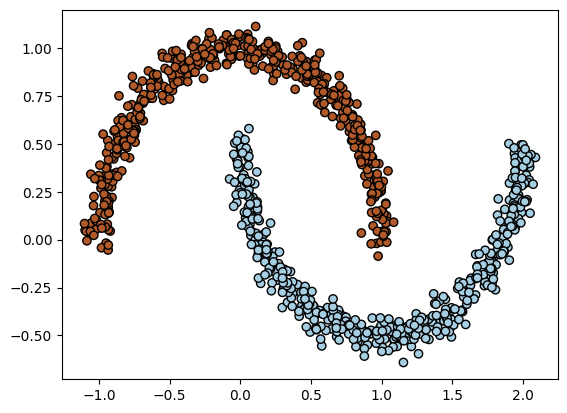

In [ ]:
# Load two moons dataset
X, y = make_moons (n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### II.1 Variational Inference with Bayesian Neural Networks

Such as for Logistic Regression, we will use `LinearVariational` layer to define a MLP with 1 hidden layer.





In [ ]:
#@title **[CODING TASK]** Implement a Variational MLP

class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size, prior_std):
        super().__init__()
        self.prior_std = prior_std


        # ============ YOUR CODE HERE ============
        # Define a variational MLP with 1 hidden layer and ReLU activation
        self.hidden_layer = LinearVariational(input_size, hidden_size, prior_std)
        self.output_layer = LinearVariational(hidden_size, 1, prior_std)  # Binary classification, output size = 1


    def kl_divergence(self):
        # ============ YOUR CODE HERE ============
        """
        Compute the KL divergence for all layers in the network
        """
        # Sum the KL divergence of each variational layer
        kl_hidden = self.hidden_layer.kl_divergence()
        kl_output = self.output_layer.kl_divergence()
        return kl_hidden + kl_output


    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        hidden = torch.relu(self.hidden_layer(x))
        output = torch.sigmoid(self.output_layer(hidden))
        return output

    def sigmas(self):
      """
      Return the average standard deviation (sigma) of all weights in the network.
      """
      sigmas = []
      for layer in [self.hidden_layer, self.output_layer]:
          sigma_layer = torch.log1p(torch.exp(layer.w_rho))
          sigmas.append(sigma_layer.mean().item())
      return sum(sigmas) / len(sigmas)

**We can now train our variational model as any other network in Pytorch**

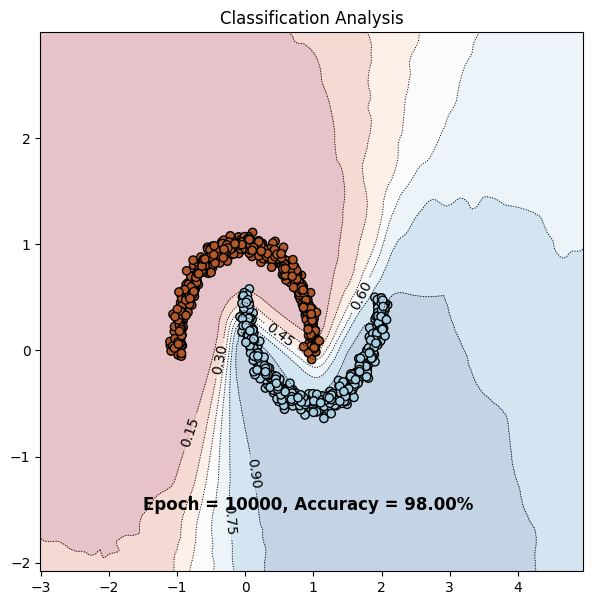

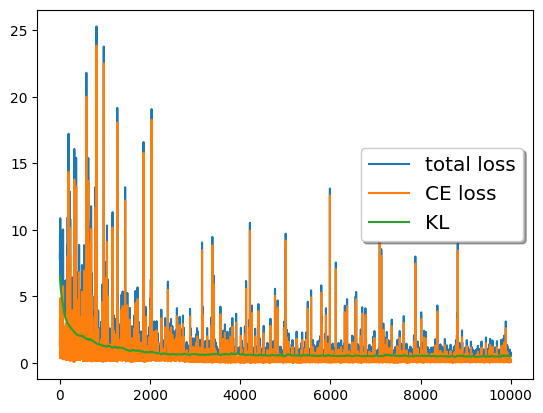

In [ ]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=50, prior_std=4)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1)

criterion = nn.BCELoss(reduction='mean')

nbEpochs=10000
beta = 4e-2

loss_plt = np.zeros((nbEpochs,5))
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(nbEpochs):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    elbo = beta * var_net.kl_divergence() + criterion(output, y)

    loss_plt[epoch,0] =elbo
    loss_plt[epoch,1] =criterion(output, y)
    loss_plt[epoch,2] =beta * var_net.kl_divergence()

    loss_plt[epoch,3] = var_net.sigmas()

    elbo.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%200==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)


fig, ax = plt.subplots()
ax.plot(np.arange(nbEpochs),loss_plt[:,0], label='total loss')
ax.plot(np.arange(nbEpochs),loss_plt[:,1], label='CE loss')
ax.plot(np.arange(nbEpochs),loss_plt[:,2], label='KL')
legend = ax.legend(loc='center right', shadow=True, fontsize='x-large')

**[Question 2.1]: Analyze the results showed on plot.**

In the first image, the background color and contour lines have the same meaning as in the previous experiments. After 10,000 epochs, the classification accuracy reaches 98%. For the moons dataset, we observe that the decision boundary is no longer linear but shows a clear curve. Additionally, the uncertainty for points far from the training data is significantly increased. This demonstrates that variational inference remains applicable to complex posterior distributions, and increasing the number of hidden layers can enhance the performance to some extent.

The second image shows the trend of CE loss, KL loss, and total loss during training. The CE loss and KL loss exhibit a fluctuating downward trend, with the KL loss steadily decreasing and stabilizing after 4,000 iterations.


### II.2 Monte Carlo Dropout

Training a neural network with randomly dropping some activations, such as with dropout layers, can actually be seen as an **approximate variational inference method**!

[Gal and Ghahramani, 2016] showed this can be fullfilled for:
- $p(\pmb{w}) = \prod_l p(\pmb{W}_l) = \prod_l \mathcal{MN}(\pmb{W}_l; 0, I/ l_i^2, I)$ $\Rightarrow$ Multivariate Gaussian distribution factorized over layers
- $q(\pmb{w}) = \prod_l q(\pmb{W}_l) = \prod_l \textrm{diag}(\varepsilon_l)\odot\pmb{M}_l $ with $\varepsilon_l \sim \textrm{Ber}(1-p_l)$.

We will now implement a MLP with dropout layers and perform Monte-Carlo sampling to obtain the predictive distribution $p(\mathbf{y} \vert \pmb{x}^*, \pmb{w})$ for a new sample $\pmb{x}^*$.

In [ ]:
#@title **[CODING TASK]** Implement a MLP with dropout (p=0.6)
# Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout
# layer should be also activated during test time.
# (Hint: we may want to look out at F.dropout())

class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # ============ YOUR CODE HERE ============
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # ============ YOUR CODE HERE ============
        # Don't forget to apply the sigmoid function when returning the output
        hidden = torch.relu(self.hidden_layer(x))
        hidden = F.dropout(hidden, p=0.6, training=True)
        output = torch.sigmoid(self.output_layer(hidden))
        return output

We train our model as usual:

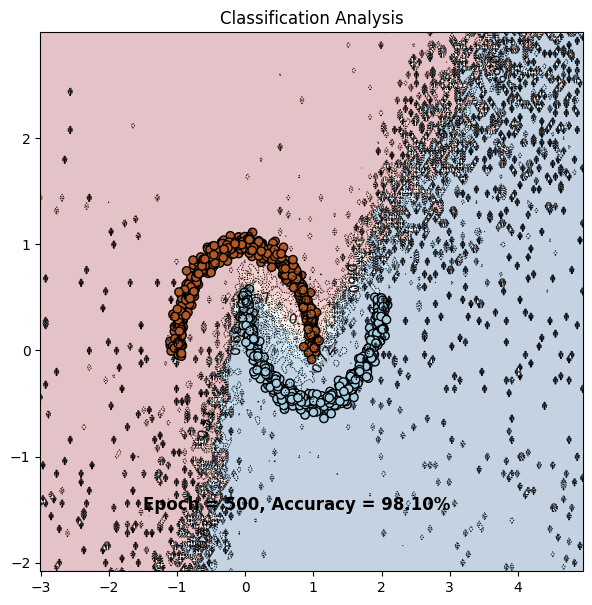

In [ ]:
net = MLP(input_size=X.shape[1], hidden_size=50)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch, uncomment and indent line below
    if (epoch+1)%50==0:
        plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='classic')


Now let's look at the results given by MC Dropout:

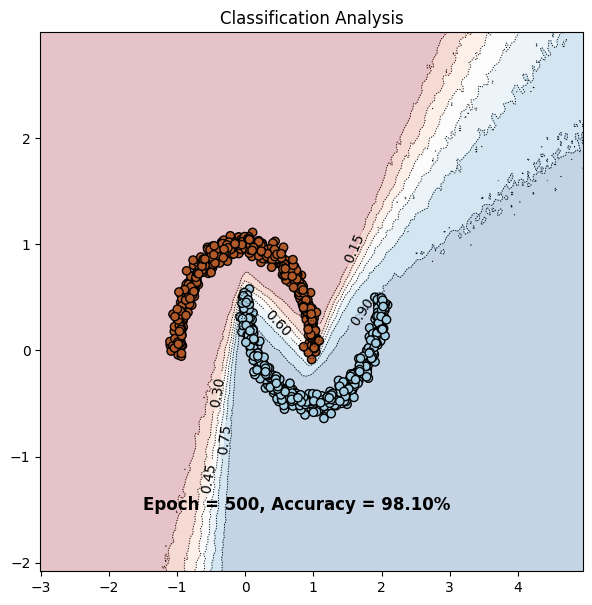

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='mcdropout', nsamples=500)

**[Question 2.2]: Again, analyze the results showed on plot. What is the benefit of MC Dropout variational inference over Bayesian Logistic Regression with variational inference?**

The figure above shows the classification results of an MLP using Monte Carlo Dropout. The background and contour lines in the plot are the same as those in the previous experiments. From the figure, we can see that after 500 epochs, the accuracy reaches 98.1%. Additionally, there are discrete circles along the contour lines, indicating that the model exhibits higher uncertainty for points far from the training data, which aligns better with real-world scenarios.

Compared to Bayesian Logistic Regression with variational inference, the model achieves 98.1% accuracy in just 500 epochs, even surpassing the results of variational inference after 10,000 epochs. MC Dropout simulates the weight distribution by randomly dropping neurons, which is more efficient than approximating the posterior distribution through variational inference. Furthermore, it performs better in handling complex nonlinear problems.
